In [52]:
import os
from itertools import product
from tqdm.notebook import trange, tqdm
import numpy as np
import matplotlib.pyplot as plt
from napari import Viewer
from tifffile import imwrite, TiffFile, imread

from glob import glob

from skimage.filters import threshold_multiotsu
from skimage.io.collection import alphanumeric_key

from scipy.ndimage import uniform_filter, correlate, convolve
from scipy.stats import pearsonr

import scipy.signal

from scipy.stats import pearsonr


from napari_5d_vibrios_viewer._widget import read_files, DaskViewer
from napari_3d_ortho_viewer._dock_widget import OrthoViewerWidget

plt.rcParams.update({"font.size": 14})

In [4]:
viewer = Viewer()
widget = DaskViewer(viewer)
viewer.window.add_dock_widget(widget)

In [58]:
path = r"C:\Henriette\2022_03_16\B2_2"
path = r"C:\Henriette\2022_03_16\D6_2"
#path = r"C:\Henriette\2022_03_16\E2_2"

In [59]:
widget.file_edit.value = path
widget._on_click()

[4, 1, 2, 3]
(25, 1, 1024, 1024)
(25, 50, 1024, 1024)
(25, 50, 1024, 1024)
(25, 50, 1024, 1024)


In [71]:
gfp = viewer.layers["GFP"].data
uniform = []
corr = []
conv = []
for i in trange(gfp.shape[0]):
    image = gfp[i, ...]
    image = uniform_filter(image, size=5)
    uniform.append(image)
    
    #corr.append(correlate(image, image))
    #conv.append(convolve(image, image))
uniform = np.stack(uniform, axis=0)
#corr = np.stack(corr, axis=0)
#conv = np.stack(conv, axis=0)
uniform.shape

  0%|          | 0/25 [00:00<?, ?it/s]

(25, 50, 1024, 1024)

In [72]:
viewer.add_image(uniform, scale=(1, 1, 0.3289, 0.3289), colormap="green")

<Image layer 'uniform' at 0x26ecc85c970>

In [73]:
mKokappa = viewer.layers["mKokappa"].data

mko_biomass = []
mko_total = []
binary = []

mko_gfp = []

for i in trange(mKokappa.shape[0]):
    image = mKokappa[i, ...]
    
    binarized = (image > 1000)
    
    mko_gfp.append(gfp[i, binarized].mean())
    
    mko_biomass.append(binarized.sum())
    mko_total.append(image.mean())
    
    binary.append(binarized)
    
binary = np.stack(binary, axis=0)

  0%|          | 0/25 [00:00<?, ?it/s]

In [74]:
viewer.add_labels(binary, scale=(1, 1, 0.3289, 0.3289))

<Labels layer 'binary' at 0x26ecfc2ed30>

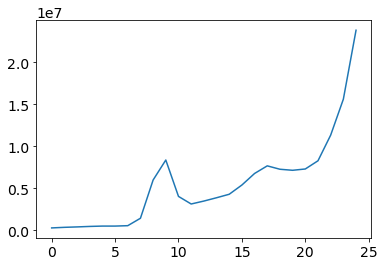

In [75]:
plt.plot(mko_biomass)

In [76]:
mKate = viewer.layers["mKate"].data

mka_biomass = np.empty((mKate.shape[0], 3))
mka_total = []

thresholds = [2000, 5000, 10000]
mka_binary = []

mka_gfp = np.empty((mKate.shape[0], 3))

for i in trange(mKokappa.shape[0]):
    image = mKate[i, ...]
    
    for j, t in enumerate(thresholds):
    
        binarized = (image > t)
        mka_gfp[i, j] = gfp[i, binarized].mean()
    
        mka_biomass[i, j] = binarized.sum()
    
    mka_total.append(image.mean())
    
    mka_binary.append(binarized)
    
mka_binary = np.stack(mka_binary, axis=0)

  0%|          | 0/25 [00:00<?, ?it/s]

C:\Users\NETTER~1\AppData\Local\Temp/ipykernel_5884/2847490951.py:17: RuntimeWarning: Mean of empty slice.
  mka_gfp[i, j] = gfp[i, binarized].mean()
d:\drescherlab\napari-5d-vibrios-viewer\dev\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


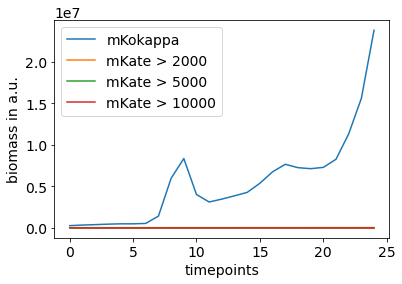

In [77]:
plt.plot(mko_biomass, label="mKokappa")

for j, t in enumerate(thresholds):
    plt.plot(mka_biomass[:, j], label=f"mKate > {t}")

ax = plt.gca()
ax.set_ylabel("biomass in a.u.")
ax.set_xlabel("timepoints")

plt.legend()

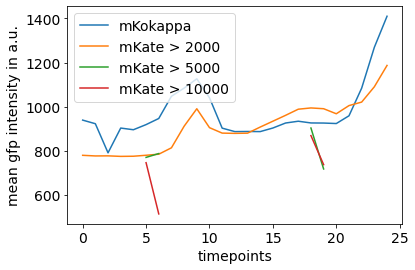

In [78]:
plt.plot(mko_gfp, label="mKokappa")

for j, t in enumerate(thresholds):
    plt.plot(mka_gfp[:, j], label=f"mKate > {t}")
    


ax = plt.gca()
ax.set_ylabel("mean gfp intensity in a.u.")
ax.set_xlabel("timepoints")

plt.legend()

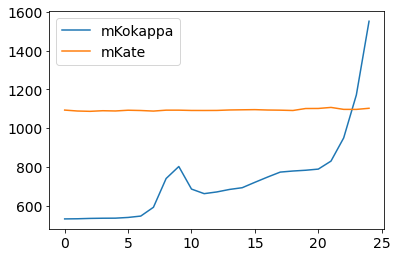

In [79]:
plt.plot(mko_total, label="mKokappa")
plt.plot(mka_total, label="mKate")

plt.legend()

In [ ]:
viewer.add_labels(mka_binary, scale=(1, 1, 0.3289, 0.3289))

In [47]:
viewer2 = Viewer()

[4, 1, 2, 3]
(1, 1, 1024, 1024)
(1, 50, 1024, 1024)
(1, 50, 1024, 1024)
(1, 50, 1024, 1024)
[4, 1, 2, 3]
(1, 1, 1024, 1024)
(1, 50, 1024, 1024)
(1, 50, 1024, 1024)
(1, 50, 1024, 1024)


In [ ]:
image = gfp[12, 14, ...]

In [ ]:
corr = scipy.signal.correlate(image, image)
conv = scipy.signal.convolve(image, image)

In [ ]:
conv.shape

In [ ]:
viewer2.add_image(corr)
viewer2.add_image(conv)

In [ ]:
viewer2.add_image(image)

In [ ]:
def mypearson(x, y):
    return pearsonr(x.flatten(), y.flatten())[0]

def mycross(x, y, num):
    new_shape = [num*2 + 1,] * x.ndim
    cross = np.empty(tuple(new_shape))
    
    center = tuple(num for _ in x.shape)
    cross[center] = 1
    
    ranges = list(range(-num, 1)) + list(range(1, num+1))
    
    for offsets in product(*[ranges,] * x.ndim):
        
        if not any(o != 0 for o in offsets):
            continue
        
        pos = tuple(num + o for o in offsets)
        
        slicesx = []
        slicesy = []
        for o in offsets:
            startslice = slice(abs(o), None)
            endslice = slice(None, -abs(o))
            if o > 0:
                slicesx.append(startslice)
                slicesy.append(endslice)
            elif o < 0:
                slicesx.append(endslice)
                slicesy.append(startslice)
            else:
                slicesx.append(slice(None))
                slicesy.append(slice(None))
        
        slicesx = tuple(slicesx)
        slicesy = tuple(slicesy)
        
        cross[pos] = mypearson(x[slicesx], y[slicesy])
    
    return cross

In [ ]:
x = np.arange(9).reshape(3, 3)
print(x)
arr = mycross(x, x, 1)
arr

In [ ]:
plt.imshow(arr)

In [ ]:
cross = mycross(image, image, 10)

In [ ]:
plt.imshow(cross)